### Dataset

In this homework, we will use the Students Performance in 2024 JAMB dataset from [Kaggle](https://www.kaggle.com/datasets/idowuadamo/students-performance-in-2024-jamb).

Here's a wget-able [link](https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv):

```bash
wget https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv
```

The goal of this homework is to create a regression model for predicting the performance of students on a standardized test (column `'JAMB_Score'`).

In [1]:
url = "https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, export_text

In [3]:
df = pd.read_csv(url)

In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head().T

,0,1,2,3,4
jamb_score,192,207,182,210,199
study_hours_per_week,22,14,29,29,12
attendance_rate,78,88,87,99,98
teacher_quality,4,4,2,2,3
distance_to_school,12.4,2.7,9.6,2.6,8.8
school_type,Public,Public,Public,Public,Public
school_location,Urban,Rural,Rural,Urban,Urban
extra_tutorials,Yes,No,Yes,No,No
access_to_learning_materials,Yes,Yes,Yes,Yes,Yes
parent_involvement,High,High,High,Medium,Medium


In [5]:
df.drop(columns='student_id', inplace=True)

In [6]:
df.isnull().sum()

jamb_score                        0
study_hours_per_week              0
attendance_rate                   0
teacher_quality                   0
distance_to_school                0
school_type                       0
school_location                   0
extra_tutorials                   0
access_to_learning_materials      0
parent_involvement                0
it_knowledge                      0
age                               0
gender                            0
socioeconomic_status              0
parent_education_level          891
assignments_completed             0
dtype: int64

In [7]:
df.fillna(0, inplace=True)

In [8]:
X = df.drop(columns='jamb_score')
y = df.jamb_score.values

In [9]:
X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=1)

In [10]:
dv = DictVectorizer(sparse=True)

X_train_dict = X_train.to_dict(orient='records')
X_train_trans = dv.fit_transform(X_train_dict)

X_val_dict = X_val.to_dict(orient='records')
X_val_trans = dv.transform(X_val_dict)

## Question 1

Let's train a decision tree regressor to predict the `jamb_score` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `study_hours_per_week`
* `attendance_rate`
* `teacher_quality`
* `distance_to_school`

In [11]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train_trans, y_train)

print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

* 22.13
* 42.13
* 62.13
* 82.12

In [12]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=1)
model = rf.fit(X_train_trans, y_train)
y_pred = model.predict(X_val_trans)
rmse = root_mean_squared_error(y_val, y_pred)
print(rmse)

42.13724207871227


## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for calculating the answer.

- 10
- 25
- 80
- 200

In [13]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=1)
    model = rf.fit(X_train_trans, y_train)
    y_pred = model.predict(X_val_trans)
    rmse = root_mean_squared_error(y_val, y_pred)
    scores.append((n, rmse))
    print(n, round(rmse, 3))


10 42.137
20 41.461
30 41.106
40 40.917
50 40.852
60 40.784
70 40.677
80 40.539
90 40.504
100 40.517
110 40.593
120 40.625
130 40.651
140 40.595
150 40.597
160 40.604
170 40.628
180 40.641
190 40.631
200 40.601


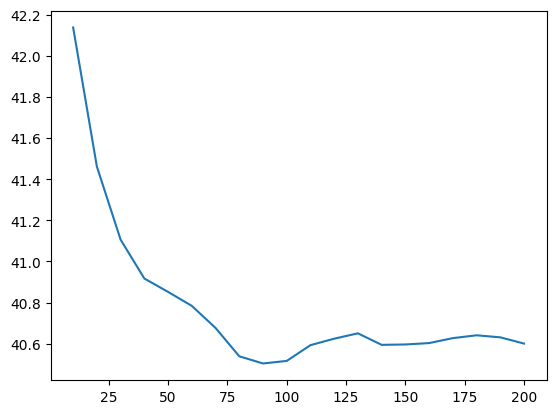

In [14]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
plt.plot(df_scores.n_estimators, df_scores.rmse)

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`


What's the best `max_depth`, using the mean RMSE?

* 10
* 15
* 20
* 25

In [15]:
scores = []
for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=1, max_depth=d)
        model = rf.fit(X_train_trans, y_train)
        y_pred = model.predict(X_val_trans)
        rmse = root_mean_squared_error(y_val, y_pred)
        scores.append((d, n, rmse))

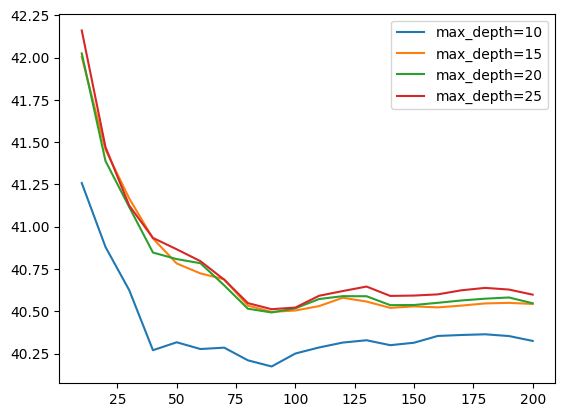

In [16]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'rmse'])
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=f'max_depth={d}')

plt.legend()

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `study_hours_per_week`
* `attendance_rate`
* `distance_to_school`
* `teacher_quality`

In [17]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=1)
model = rf.fit(X_train_trans, y_train)

In [18]:
features = list(dv.get_feature_names_out())
feature_importances = list(zip(features, model.feature_importances_))
sorted(feature_importances, key=lambda x: x[1], reverse=True)[:10]


[('study_hours_per_week', np.float64(0.24835361199396536)),
 ('attendance_rate', np.float64(0.1497290297846747)),
 ('distance_to_school', np.float64(0.1364858048632369)),
 ('teacher_quality', np.float64(0.0826822226388016)),
 ('age', np.float64(0.06931145469695398)),
 ('assignments_completed', np.float64(0.03151678945460071)),
 ('socioeconomic_status=High', np.float64(0.025714264343587142)),
 ('parent_involvement=High', np.float64(0.022918852929064194)),
 ('it_knowledge=High', np.float64(0.0177193420394119)),
 ('parent_education_level=Secondary', np.float64(0.016956919815100068))]

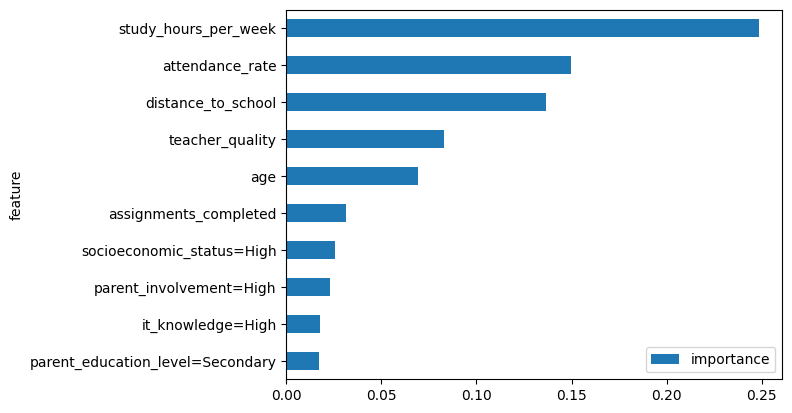

In [19]:
df_fi = pd.DataFrame(feature_importances, columns=['feature', 'importance']).sort_values(by='importance', ascending=False)
df_fi.head(10).plot(kind='barh', y="importance", x="feature")
plt.gca().invert_yaxis()

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value

In [48]:
import xgboost as xgb

In [49]:
dtrain = xgb.DMatrix(X_train_trans, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val_trans,label=y_val, feature_names=features)

watchlist = [(dtrain, 'train'), (dval, 'val')]

In [50]:
%%capture output1

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=100)

In [51]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [52]:
scores = {}

In [53]:
key = f"eta={xgb_params['eta']}"
scores[key] = parse_xgb_output(output1)
key, scores[key]

('eta=0.3',
     num_iter  train_rmse  val_rmse
 0          0    42.69384  44.89114
 1          1    39.83326  43.07010
 2          2    37.94542  42.00332
 3          3    36.56125  41.46452
 4          4    35.44252  40.88896
 ..       ...         ...       ...
 95        95    11.95568  43.37919
 96        96    11.76819  43.39410
 97        97    11.58218  43.40203
 98        98    11.53812  43.40245
 99        99    11.39140  43.41882
 
 [100 rows x 3 columns])

In [56]:
%%capture output1
xgb_params['eta'] = 0.1
xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=100)


key = f"eta={xgb_params['eta']}"
scores[key] = parse_xgb_output(output1)
key, scores[key]

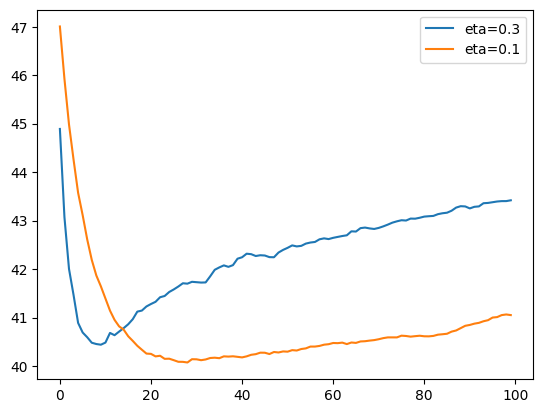

In [57]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=key)
plt.legend()